In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import julian
from modelsAdvanced import ModelFunc, linearModel
import os

In [ ]:
kind = 'Pdot'  # 'Linear', 'Pdot'
target = 'WASP-107b'
outdir = 'plots'
suffix = ''
MF = ModelFunc(kind)
Model = MF.get_model()
indir = 'wasp-107b/0/Nonesigma'
linear_posteriors = json.load(open(f'{indir}/Linear/posteriors.json'))
pdot_posteriors = json.load(open(f'{indir}/Pdot/posteriors.json'))
posterior_data = pd.read_csv(f'{indir}/Pdot/posterior_data.csv')
posterior_data

Using Pdot model
Using Pdot model


,T_mid,Uncertainty,Label,Reference,type,Epoch,Valid,T_mid_pre,Residual
0,2.457584e+06,0.000032,K2,2017AJ....153..205D,transit,0,True,2.457584e+06,0.000039
1,2.457905e+06,0.000047,HST,This work,transit,56,True,2.457905e+06,-0.000060
2,2.457910e+06,0.000046,HST,This work,transit,57,True,2.457910e+06,-0.000048
3,2.458580e+06,0.000429,TESS-I&W,Ivshina & Winn 2022,transit,174,True,2.458580e+06,-0.000225
4,2.458591e+06,0.000355,TESS-I&W,Ivshina & Winn 2022,transit,176,True,2.458591e+06,-0.000080
5,2.459959e+06,0.000034,JWST,This work,transit,415,True,2.459959e+06,0.000023
6,2.459964e+06,0.000012,JWST,This work,transit,416,True,2.459964e+06,0.000020
7,2.460108e+06,0.000010,JWST,This work,transit,441,True,2.460108e+06,-0.000026
8,2.460119e+06,0.000021,JWST,This work,transit,443,True,2.460119e+06,0.000007
9,2.460130e+06,0.000027,JWST,This work,transit,445,True,2.460130e+06,0.000065


In [3]:
t0_ecl = 2460487.58

/tmp/ipykernel_19394/2248145462.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


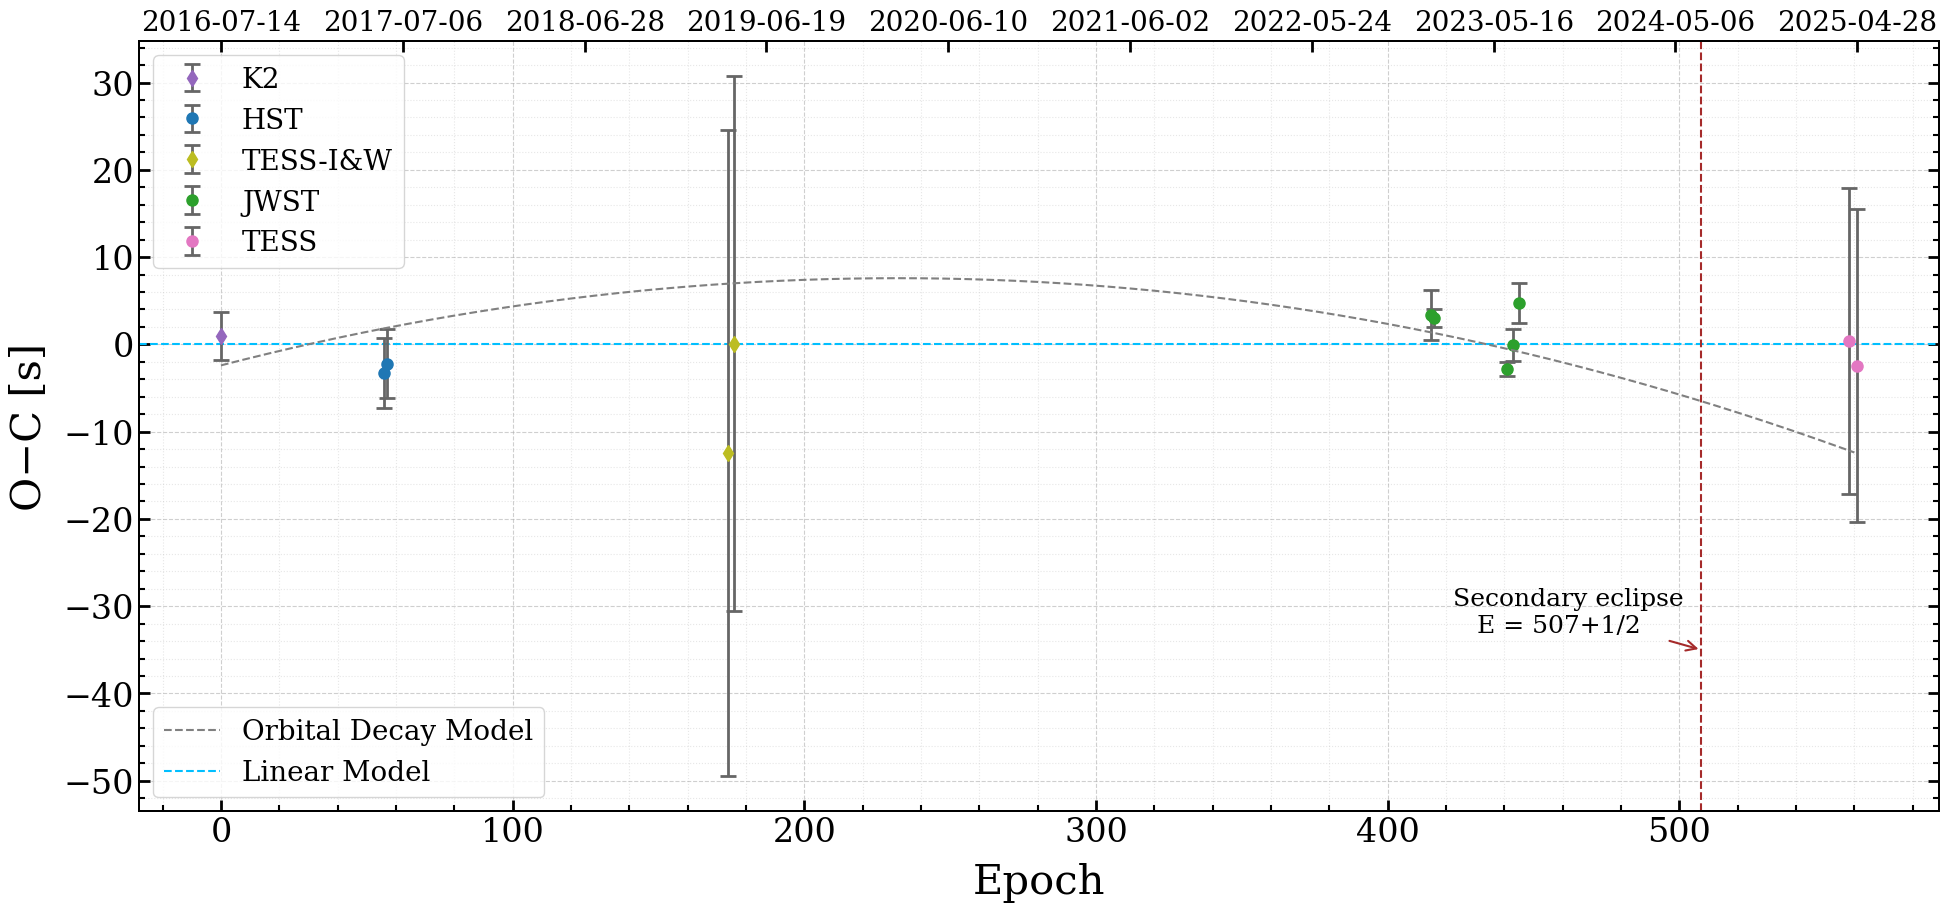

In [4]:
plt.rcParams.update({
    'font.size': 18,
    'font.family': 'serif',
    'axes.linewidth': 1.4,
    'xtick.major.size': 8,
    'ytick.major.size': 8,
    'xtick.minor.size': 4,
    'ytick.minor.size': 4,
    'axes.labelpad': 8,
    'lines.linewidth': 1.8,
    'lines.markersize': 10,
    'axes.titlepad': 15,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'xtick.major.width': 2.0,
    'ytick.major.width': 2.0,
    'xtick.minor.width': 1.5,
    'ytick.minor.width': 1.5,
})
data = posterior_data.copy()
N = data['Epoch'].max()
params = pdot_posteriors['params']
lin_parameters = linear_posteriors['params']
names = pdot_posteriors['names']
parameters_pre = pdot_posteriors['parameters_pre']
E_ecl = np.round((t0_ecl - lin_parameters[1]/2 - data['T_mid'].min())/(lin_parameters[1])) + 1/2

unitt = 's'
unit_conversion = {'s': 86400, 'min': 1440, 'h': 24}
multi = unit_conversion.get(unitt, 1)

# Color management
cmap = plt.cm.get_cmap('tab10')
unique_labels = sorted(set(data['Label']))
color_dict = {label: cmap(i/len(unique_labels)) for i, label in enumerate(unique_labels)}

mask = data['Valid']
numbers = data[mask].index

fig, ax = plt.subplots(figsize=(24, 10))
fig.subplots_adjust(left=0.1, right=0.85)

# Common plot elements
base_zorder = 10
errorbar_kwargs = {
    # 'fmt': 'o',
    'ms': 8,
    'capsize': 6,
    'capthick': 2,
    'elinewidth': 2,
    'zorder': base_zorder
}

dots_axes = []
line_axes = []

if 'Linear' in kind:
    # Linear model plotting
    valid_data = data[mask]
    for i in numbers:
        ax.errorbar(valid_data.loc[i,'Epoch'], (valid_data.loc[i,'T_mid']-valid_data.loc[i,'T_mid_pre'])*multi, fmt='o' if valid_data.loc[i,'Reference'] == 'This work' else 'd',
                    yerr=valid_data.loc[i,'Uncertainty']*multi,label=valid_data.loc[i,'Label'],
                    color=color_dict[valid_data.loc[i,'Label']],
                    ecolor='#666666',**errorbar_kwargs)

    if not np.all(mask):
        invalid_data = data[~mask]
        ax.errorbar(invalid_data['Epoch'],
                (invalid_data['T_mid'] - invalid_data['T_mid_pre']) * multi,
                yerr=invalid_data['Uncertainty'] * multi,
                color='#AAAAAA',
                ecolor='#888888',
                label='Outliers',
                alpha=0.6,
                **errorbar_kwargs)

    ax.axhline(0, c='k', lw=1.5, ls='--', zorder=base_zorder-1, label = 'Linear Fit')
    

else:
    t_pre = np.array(Model(params,N))
    if lin_parameters is None:
        t_pre_l = np.array(linearModel(params[:2],N))
        t_tras_lin = linearModel(params[:2],N)
        t_mids_lin = []
        for i in range(len(data['Epoch'])):
            t_mids_lin.append(t_tras_lin[data['Epoch'][i]])
        data_lin_pre = np.array(t_mids_lin)
    else:
        t_pre_l = np.array(linearModel(lin_parameters,N))
        t_tras_lin = linearModel(lin_parameters,N)
        t_mids_lin = []
        for i in range(len(data['Epoch'])):
            t_mids_lin.append(t_tras_lin[data['Epoch'][i]])
        data_lin_pre = np.array(t_mids_lin)
    # Non-linear model plotting
    t_pre = np.array(Model(params, N))
    t_pre_l = np.array(linearModel(params[:2], N)) if lin_parameters is None \
            else np.array(linearModel(lin_parameters, N))
    
    model_line, = ax.plot(range(N), (t_pre[:N] - t_pre_l[:N]) * multi,
                        # color='#66ccff',
                        color='gray',
                        ls='--',
                        lw=1.5,
                        zorder=base_zorder+1,
                        label='Orbital Decay Model')

    valid_data = data[mask]
    for i in numbers:
        ax.errorbar(valid_data.loc[i,'Epoch'], (valid_data.loc[i,'T_mid']-data_lin_pre[i])*multi, fmt='o' if valid_data.loc[i,'Reference'] == 'This work' else 'd',
                    yerr=valid_data.loc[i,'Uncertainty']*multi,
                    label=valid_data.loc[i,'Label'],color=color_dict[valid_data.loc[i,'Label']],
                    ecolor='#666666',
                    **errorbar_kwargs)

    if not np.all(mask):
        invalid_data = data[~mask]
        ax.errorbar(invalid_data['Epoch'],
                (invalid_data['T_mid'] - data_lin_pre[~mask]) * multi,
                yerr=invalid_data['Uncertainty'] * multi,
                color='#AAAAAA',
                ecolor='#888888',
                label='Outliers',
                alpha=0.6,
                **errorbar_kwargs)

    ax.axhline(0, c='deepskyblue', lw=1.5, ls='--', zorder=base_zorder-1,  label = 'Linear Model')

# Date formatting
if 'Date' not in data.columns:
    data['Date'] = [julian.from_jd(x) for x in data['T_mid']]
date_label = pd.date_range(
    start=data['Date'][0],
    end=data['Date'][len(data['Date'])-1],
    periods=10
)
date_ticks = np.linspace(data['Epoch'][0],data['Epoch'][len(data['Epoch'])-1],10)
xlim = ax.get_xlim()
axT = ax.twiny()
axT.set_xlim(xlim)
axT.set_xticks(date_ticks,[i.strftime('%Y-%m-%d') for i in date_label])
axT.tick_params(axis='x', which='major', labelsize=20, direction='in')
# Axis labeling
ax.set_ylabel(f"O−C [{unitt}]", fontsize=30, labelpad=10)
ax.set_xlabel("Epoch", fontsize=30, labelpad=10)
ax.minorticks_on()
ax.tick_params(axis='both', which='both', labelsize=24, direction='in',right=True)

# Grid and ticks
ax.grid(True, which='major', ls='--', alpha=0.6)
ax.grid(True, which='minor', ls=':', alpha=0.3)
# ax.axvline(E_ecl, c='k', lw=1.5, ls='--', zorder=base_zorder-1,  label = 'Linear Model')
ax.axvline(E_ecl, c='brown', lw=1.5, ls='--', zorder=base_zorder-1)
ax.annotate('Secondary eclipse\n   E = %d+1/2'%(E_ecl-0.5), (E_ecl, -35), (E_ecl-85, -33), arrowprops=dict(arrowstyle='->', color='brown', lw=1.5))

# Legend handling
handles, labels = ax.get_legend_handles_labels()
unique_labels = []
unique_handles = []
for h, l in zip(handles, labels):
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

# ax.legend(unique_handles, unique_labels,
#         borderaxespad=0.,
#         fontsize=20,
#         )

dots_hls = []
dots_las = []
line_hls = []
line_las = []
for h, l in zip(unique_handles, unique_labels):
    if 'Model' in l:
        line_hls.append(h)
        line_las.append(l)
    else:
        dots_hls.append(h)
        dots_las.append(l)
first_legend = ax.legend(line_hls, line_las, fontsize=20, loc='lower left')
second_legend = ax.legend(dots_hls, dots_las, fontsize=20, loc='upper left')
ax.add_artist(first_legend)
# if kind != 'Linear':
#     if kind=='Pdot':
#         unit = 'ms/yr'
#     elif kind=='Sine':
#         unit = 's'
#     else:
#         unit = 'radian/epoch'
#     ax.set_title(f"{target} TTV Fit, " + r'%s$ = %.2f\pm%.2f\ %s$'%(names[-1],parameters_pre[-1][0],np.abs(np.max(parameters_pre[-1][1:])),unit), fontsize=34, pad=15)
# else:
#     ax.set_title(f"{target} TTV Fit: {kind} Model", fontsize=34, pad=15)
# ax.text(0.98, 0.02, f"{target} TTV Fit: {kind} Model", fontsize=34, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
# ax.text(0.90, 0.10, r'%s$ = %.2f\pm%.2f\ ms / yr$'%(names[-1],parameters_pre[-1][0],np.abs(np.max(parameters_pre[-1][1:]))), fontsize=30, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

if 'Linear' in kind:
    only_data = data[data['Reference']=='This work'].copy()
    fig_l, ax_l = plt.subplots(figsize=(24, 10), dpi=100)
    fig_l.subplots_adjust(left=0.1, right=0.85)
    ax_l.errorbar(only_data['Epoch'], (only_data['T_mid']-only_data['T_mid_pre'])*multi, 
                yerr=only_data['Uncertainty']*multi,label=only_data['Label'],
                ecolor='#666666',**errorbar_kwargs)
    ax_l.axhline(0, c='k', lw=1.5, ls='--', zorder=base_zorder-1)
if outdir is not None:
    if not outdir.endswith('/'):
        outdir += '/'
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    fig.savefig(f"{outdir}plot_{kind}_{target.replace(' ', '-')}{suffix}.png", dpi=300, bbox_inches='tight')
    fig.savefig(f"{outdir}plot_{kind}_{target.replace(' ', '-')}{suffix}.pdf", bbox_inches='tight')
    fig.savefig(f"{outdir}plot_{kind}_{target.replace(' ', '-')}_transparent{suffix}.pdf", bbox_inches='tight', transparent=True)
    # if 'Linear' in kind:
    #     fig_l.savefig(f"{outdir}plot_only{suffix}.png", dpi=300, bbox_inches='tight')
    #     fig_l.savefig(f"{outdir}plot_only{suffix}.pdf", bbox_inches='tight')
    #     fig_l.savefig(f"{outdir}plot_only_transparent{suffix}.pdf", bbox_inches='tight', transparent=True)

In [5]:
E_ecl

507.5